#DATA PROCESSING 

In [10]:
import os
os.environ["OMP_NUM_THREADS"] = "1"


In [11]:
import pandas as pd
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch
import numpy as np
import pprintpp as pp
import re
import gc
import numpy

In [12]:
data1 = pd.read_csv('data/tmdb_5000_credits.csv')
data2 = pd.read_csv('data/tmdb_5000_movies.csv')

In [13]:
def set_seed(seed):
    
    torch.cuda.manual_seed(seed)
    torch.manual_seed(seed) #all cpus
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


    return None
    

In [14]:
seed = set_seed(1234)

In [15]:
#set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [16]:
data1.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [17]:
data1.title.head()

0                                      Avatar
1    Pirates of the Caribbean: At World's End
2                                     Spectre
3                       The Dark Knight Rises
4                                 John Carter
Name: title, dtype: object

In [18]:
data1.describe(include='all')

,movie_id,title,cast,crew
count,4803.000000,4803,4803,4803
unique,NaN,4800,4761,4776
top,NaN,The Host,[],[]
freq,NaN,2,43,28
mean,57165.484281,NaN,NaN,NaN
std,88694.614033,NaN,NaN,NaN
min,5.000000,NaN,NaN,NaN
25%,9014.500000,NaN,NaN,NaN
50%,14629.000000,NaN,NaN,NaN
75%,58610.500000,NaN,NaN,NaN


In [19]:
pp.pprint(data1.cast[0])

'[{"cast_id": 242, "character": "Jake Sully", "credit_id": "5602a8a7c3a3685532001c9a", "gender": 2, "id": 65731, "name": "Sam Worthington", "order": 0}, {"cast_id": 3, "character": "Neytiri", "credit_id": "52fe48009251416c750ac9cb", "gender": 1, "id": 8691, "name": "Zoe Saldana", "order": 1}, {"cast_id": 25, "character": "Dr. Grace Augustine", "credit_id": "52fe48009251416c750aca39", "gender": 1, "id": 10205, "name": "Sigourney Weaver", "order": 2}, {"cast_id": 4, "character": "Col. Quaritch", "credit_id": "52fe48009251416c750ac9cf", "gender": 2, "id": 32747, "name": "Stephen Lang", "order": 3}, {"cast_id": 5, "character": "Trudy Chacon", "credit_id": "52fe48009251416c750ac9d3", "gender": 1, "id": 17647, "name": "Michelle Rodriguez", "order": 4}, {"cast_id": 8, "character": "Selfridge", "credit_id": "52fe48009251416c750ac9e1", "gender": 2, "id": 1771, "name": "Giovanni Ribisi", "order": 5}, {"cast_id": 7, "character": "Norm Spellman", "credit_id": "52fe48009251416c750ac9dd", "gender": 

In [20]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  4803 non-null   int64 
 1   title     4803 non-null   object
 2   cast      4803 non-null   object
 3   crew      4803 non-null   object
dtypes: int64(1), object(3)
memory usage: 150.2+ KB


In [21]:
data2.id[0],data1.movie_id[0]

(19995, 19995)

In [22]:
from  pandasql import sqldf
df = sqldf("""
    SELECT * 
    FROM data1 
    FULL JOIN data2 
    ON  data1.movie_id = data2.id
""")

In [23]:
df.columns

Index(['movie_id', 'title', 'cast', 'crew', 'budget', 'genres', 'homepage',
       'id', 'keywords', 'original_language', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title', 'vote_average', 'vote_count'],
      dtype='object')

In [24]:
df.genres[0]

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

In [25]:
def extract_names(data):
    #for genres companies and keywords

    pattern = re.compile(r'"name":\s* "([^"]+)"')
            
    

    genres = re.findall(pattern,df.genres[0])

    data = genres

    return data

In [26]:
def preprocess(df):
    #drop id
    df.drop('id',inplace=True)
    
    #date to numeric
    pd.to_numeric(df['vote_average'])
    
    #replace zero values with mean 
    df['budget']=  [int(df['budget']).mean() for v in df['budget'] if v == 0 ]
    
    #fill webpages 
    df.homepage.fillna(f"www.{df.title.strip()}+.com")
    
    #release date to datetime 
    
    df['release_date'] = pd.to_datetime(df['release_date'], format='%Y-%m-%d', errors='coerce').dt.date
    
    #clean overview and tagline columns 
    pattern = re.compile('[!@#$%^&*()<>]')
    df.overview.apply(clean())
    df.tagline.apple(clean)
    return df
 

In [27]:
df.overview[0]

'In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.'

In [28]:
def extract_cast(data):
    pattern  = re.compile(r'"character":\s*"([^"]+)"')
    cast = re.findall(pattern,df.cast[0])
    data = cast 
    return data

In [29]:
def extract_names(data):
    pattern = re.compile(r'"name":\s*"([^"]+)"')
    names = re.findall(pattern,data)
    data = names 
    return data 


In [30]:
df.isnull().sum()

movie_id                   0
title                      0
cast                       0
crew                       0
budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
dtype: int64

In [31]:
df.tagline.fillna('',inplace=True)
df.runtime.fillna(df.runtime.mean(),inplace=True)
df.homepage.fillna('',inplace=True)
df.overview.fillna('',inplace=True)
df.release_date.fillna(np.random.choice(df['release_date']),inplace=True)


/var/folders/9m/fk8nf0sd56b7drjkrkbjx7580000gn/T/ipykernel_91149/526472228.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.tagline.fillna('',inplace=True)
/var/folders/9m/fk8nf0sd56b7drjkrkbjx7580000gn/T/ipykernel_91149/526472228.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

In [32]:
df.isnull().sum()

movie_id                0
title                   0
cast                    0
crew                    0
budget                  0
genres                  0
homepage                0
id                      0
keywords                0
original_language       0
original_title          0
overview                0
popularity              0
production_companies    0
production_countries    0
release_date            0
revenue                 0
runtime                 0
spoken_languages        0
status                  0
tagline                 0
title                   0
vote_average            0
vote_count              0
dtype: int64

In [33]:
def drop_columns(df):

   columns_to_drop = ['title','spoken_languages','crew','production_countries','spoken_languages']

   for column in columns_to_drop:
      df.drop(column,axis = 1,inplace=True)

   return df 
   

In [34]:
df['cast'] = df.cast.apply(lambda x: extract_names(x))

In [35]:
df.head(1)

,movie_id,title,cast,crew,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,19995,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


In [36]:
df['genres'] = df.genres.apply(lambda x: extract_names(x))

In [37]:
df['keywords'] = df.keywords.apply(lambda x: extract_names(x))

In [38]:
df['production_companies'] = df.production_companies.apply(lambda x: extract_names(x))

In [39]:
df.drop('id',axis = 1,inplace=True)

In [40]:
def join_names(c):
    #c - > column
    columns_to_join =['cast','genres','keywords','overview','tagline']
    
    ''.join()

In [41]:
df.columns

Index(['movie_id', 'title', 'cast', 'crew', 'budget', 'genres', 'homepage',
       'keywords', 'original_language', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title', 'vote_average', 'vote_count'],
      dtype='object')

In [42]:
df_new = df[['movie_id', 'cast', 'genres', 'keywords',
       'original_title', 'overview','release_date','tagline','popularity','production_companies','vote_average']]

In [43]:
df_new.isna().sum()

movie_id                0
cast                    0
genres                  0
keywords                0
original_title          0
overview                0
release_date            0
tagline                 0
popularity              0
production_companies    0
vote_average            0
dtype: int64

In [44]:
def merge_name(column):
    column = " ".join(column)
    return column


In [45]:
df_new['cast'] = df['cast'].apply(lambda x: merge_name(x) )
df_new['genres'] = df['genres'].apply(lambda x: merge_name(x) )
df_new['production_companies'] = df['production_companies'].apply(lambda x: merge_name(x) )
df_new['keywords'] = df['keywords'].apply(lambda x: merge_name(x) )



/var/folders/9m/fk8nf0sd56b7drjkrkbjx7580000gn/T/ipykernel_91149/4194281060.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['cast'] = df['cast'].apply(lambda x: merge_name(x) )
/var/folders/9m/fk8nf0sd56b7drjkrkbjx7580000gn/T/ipykernel_91149/4194281060.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['genres'] = df['genres'].apply(lambda x: merge_name(x) )
/var/folders/9m/fk8nf0sd56b7drjkrkbjx7580000gn/T/ipykernel_91149/4194281060.py:3: SettingWithCopyWarning: 
A value is trying to be s

In [46]:
df_new['description'] = df_new['cast'] + " " + df_new['genres']+ " " + df_new['keywords'] + " " + df_new['overview'] + " " + df_new['tagline'] + df_new['production_companies'] + ' ' + df_new['original_title']

/var/folders/9m/fk8nf0sd56b7drjkrkbjx7580000gn/T/ipykernel_91149/2770353643.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['description'] = df_new['cast'] + " " + df_new['genres']+ " " + df_new['keywords'] + " " + df_new['overview'] + " " + df_new['tagline'] + df_new['production_companies'] + ' ' + df_new['original_title']


In [47]:
df_new.drop(['cast', 'genres', 'keywords','movie_id','overview','tagline','production_companies','original_title'],axis = 1,inplace=True)

/var/folders/9m/fk8nf0sd56b7drjkrkbjx7580000gn/T/ipykernel_91149/3532397165.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.drop(['cast', 'genres', 'keywords','movie_id','overview','tagline','production_companies','original_title'],axis = 1,inplace=True)


In [48]:
df_new['release_date'] = pd.to_datetime(df_new['release_date'],errors='coerce').dt.year

/var/folders/9m/fk8nf0sd56b7drjkrkbjx7580000gn/T/ipykernel_91149/3269401829.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['release_date'] = pd.to_datetime(df_new['release_date'],errors='coerce').dt.year


In [49]:
df_new.head()


,release_date,popularity,vote_average,description
0,2009,150.437577,7.2,Sam Worthington Zoe Saldana Sigourney Weaver S...
1,2007,139.082615,6.9,Johnny Depp Orlando Bloom Keira Knightley Stel...
2,2015,107.376788,6.3,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...
3,2012,112.312950,7.6,Christian Bale Michael Caine Gary Oldman Anne ...
4,2012,43.926995,6.1,Taylor Kitsch Lynn Collins Samantha Morton Wil...


In [50]:
df_new.isnull().sum()

release_date    0
popularity      0
vote_average    0
description     0
dtype: int64

In [51]:
def process_description(text):
    # Check if the input is not a string (e.g., it's NaN or float)
    if not isinstance(text, str):
        return ''  # Or you could return None or just the text if preferred
    
    # Step 1: Remove special characters (optional)
    pattern1 = re.compile(r'[!@#$%^&*(){}?<>|/]')
    text = re.sub(pattern1, '', text)
    
    # Step 2: Remove any non-alphanumeric characters (keep only letters, digits, and spaces)
    pattern2 = re.compile(r'[^A-Za-z\s]')
    text = re.sub(pattern2, '', text)
    
    
    
    # Step 4: Return the processed tokens (or string, depending on your needs)
    return text

# Apply the function to the 'description' column
df_new['description'] = df_new['description'].apply(process_description)

/var/folders/9m/fk8nf0sd56b7drjkrkbjx7580000gn/T/ipykernel_91149/849182033.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['description'] = df_new['description'].apply(process_description)


In [52]:
df_new.head()

,release_date,popularity,vote_average,description
0,2009,150.437577,7.2,Sam Worthington Zoe Saldana Sigourney Weaver S...
1,2007,139.082615,6.9,Johnny Depp Orlando Bloom Keira Knightley Stel...
2,2015,107.376788,6.3,Daniel Craig Christoph Waltz Luea Seydoux Ralp...
3,2012,112.312950,7.6,Christian Bale Michael Caine Gary Oldman Anne ...
4,2012,43.926995,6.1,Taylor Kitsch Lynn Collins Samantha Morton Wil...


In [53]:
#Scaling Data

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

In [54]:
import torch

In [55]:
def scale_data(df):
    vectorizer = TfidfVectorizer()
    

    df['scaled_text'] = vectorizer.fit_transform(df['description']).toarray()
    df['scaled_nums'] = torch.asarray(StandardScaler.fit_transform(df[['release_date','popularity','vote_average']]))
    df['avg_vote'] = vectorizer.fit_transform(df['vote_average']).toarray()
    return df

In [56]:
def list_to_text(text):
        text = ' '.join(text)
        return text


In [57]:
df_new.description[0]

'Sam Worthington Zoe Saldana Sigourney Weaver Stephen Lang Michelle Rodriguez Giovanni Ribisi Joel David Moore CCH Pounder Wes Studi Laz Alonso Dileep Rao Matt Gerald Sean Anthony Moran Jason Whyte Scott Lawrence Kelly Kilgour James Patrick Pitt Sean Patrick Murphy Peter Dillon Kevin Dorman Kelson Henderson David Van Horn Jacob Tomuri Michael BlainRozgay Jon Curry Luke Hawker Woody Schultz Peter Mensah Sonia Yee Jahnel Curfman Ilram Choi Kyla Warren Lisa Roumain Debra Wilson Chris Mala Taylor Kibby Jodie Landau Julie Lamm Cullen B Madden Joseph Brady Madden Frankie Torres Austin Wilson Sara Wilson Tamica WashingtonMiller Lucy Briant Nathan Meister Gerry Blair Matthew Chamberlain Paul Yates Wray Wilson James Gaylyn Melvin Leno Clark III Carvon Futrell Brandon Jelkes Micah Moch Hanniyah Muhammad Christopher Nolen Christa Oliver April Marie Thomas Bravita A Threatt Colin Bleasdale Mike Bodnar Matt Clayton Nicole Dionne Jamie Harrison Allan Henry Anthony Ingruber Ashley Jeffery Dean Knowsl

In [58]:
#scaling numbers
Scaler = StandardScaler()
scaled_date = Scaler.fit_transform(df_new[['release_date']])
scaled_popularity = Scaler.fit_transform(df_new[['popularity']])  
scaled_avg_vote = Scaler.fit_transform(df_new[['vote_average']])  
                                 

In [59]:
#scaling text 
vectorizer = TfidfVectorizer()
    
scaled_text  = vectorizer.fit_transform(df_new['description']).toarray()

In [60]:
len(scaled_text)

4803

In [61]:
feature_names = vectorizer.get_feature_names_out()

In [62]:
avg_tfidf_scores = scaled_text.mean(axis=0)
top_term_indices = np.argsort(avg_tfidf_scores)[-10:][::-1]  # Top 10 terms
top_terms = [(feature_names[idx], avg_tfidf_scores[idx]) for idx in top_term_indices]
print("Top terms across the corpus by average TF-IDF score:", top_terms)


Top terms across the corpus by average TF-IDF score: [('the', 0.06096229905349316), ('to', 0.035043662756455304), ('of', 0.03440676326081741), ('and', 0.033148901102058405), ('in', 0.024580627388194165), ('his', 0.024405104170338924), ('is', 0.021713668514616154), ('her', 0.01858576958741494), ('with', 0.016509218464602363), ('he', 0.01613125358412122)]


In [63]:
#top 10 words
words = []
tf_scores = []
for term in top_terms:  
    word,score = term[0],term[1]
    words.append(word)
    tf_scores.append(score)
data = dict(zip(words,tf_scores))
top_words_dataframe = pd.DataFrame({'words': words,'tf-idf score': tf_scores})

top_words_dataframe

    
    

,words,tf-idf score
0,the,0.060962
1,to,0.035044
2,of,0.034407
3,and,0.033149
4,in,0.024581
5,his,0.024405
6,is,0.021714
7,her,0.018586
8,with,0.016509
9,he,0.016131


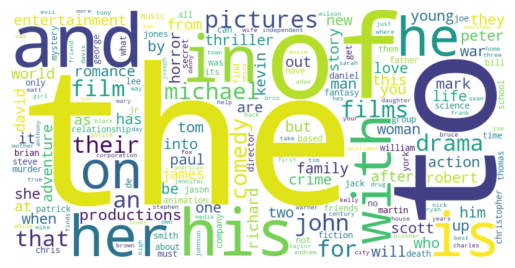

In [64]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Average TF-IDF score for each word across documents
tfidf_scores_dict = dict(zip(feature_names, avg_tfidf_scores))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_scores_dict)


plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [65]:
#constructing tensors
scaled_text = torch.tensor(data =  scaled_text,dtype = torch.float32)
scaled_date = torch.tensor(data = scaled_date,dtype=torch.float32)
scaled_popularity = torch.tensor(data = scaled_popularity,dtype=torch.float32)
scaled_avg_vote = torch.tensor(data = scaled_avg_vote,dtype = torch.float32)


In [66]:
len(scaled_text),len(scaled_popularity),len(scaled_avg_vote)

(4803, 4803, 4803)

In [67]:
len(df)

4803

In [68]:
tensor_dataset = torch.cat([scaled_avg_vote,scaled_date,scaled_popularity,scaled_text],dim = 1)

In [69]:
len(tensor_dataset)

4803

In [70]:
df['original_title']

0                                         Avatar
1       Pirates of the Caribbean: At World's End
2                                        Spectre
3                          The Dark Knight Rises
4                                    John Carter
                          ...                   
4798                                 El Mariachi
4799                                   Newlyweds
4800                   Signed, Sealed, Delivered
4801                            Shanghai Calling
4802                           My Date with Drew
Name: original_title, Length: 4803, dtype: object

In [71]:
tensor_dataset[0]

tensor([0.9275, 0.5263, 4.0532,  ..., 0.0000, 0.0000, 0.0000])

In [72]:
import torch
from torch.utils.data import Dataset

class Movie_Dataset(Dataset):
    def __init__(self, tensor_dataset, df):
        # tensor_dataset is the feature embeddings, df is the DataFrame containing movie data
        self.data = tensor_dataset
        self.labels = list(df['original_title'])
    
    def __repr__(self):
        info = f'Movie Dataset No. of samples: {len(self.data)}'
        return info
    
    def train_test_split(self, train_ratio=0.8):
        # Default train-test split is 80-20
        self.train_size = int(train_ratio * len(self.data))
        train_data = self.data[:self.train_size]
        test_data = self.data[self.train_size:]
        return train_data, test_data

    def __getitem__(self, index):
        # Returns the feature embedding (anchor) and its corresponding label
        anchor = self.data[index]
        label = self.labels[index]
        return anchor, label
    
    def get_movie_embedding(self, label):
        # Get the embedding for a given movie label
        idx = self.labels.index(label)
        return self.data[idx]

    def get_label(self, embedding):
        # Get the label (movie title) for a given embedding
        tensors = list(self.data)
        for idx, tensor in enumerate(tensors):
            if torch.equal(tensor, embedding):  # Compare tensors for exact match
                return self.labels[idx]
        return None  # Return None if embedding is not found
    
     


         

In [73]:
movie_dataset = Movie_Dataset(tensor_dataset,df)
train_data,test_data = movie_dataset.train_test_split()
train_loader = DataLoader(train_data,
                    batch_size=100,
                    shuffle = False,
                    num_workers=3)
test_loader = DataLoader(test_data,
                    batch_size=100,
                    shuffle = False,
                    num_workers=3)

In [74]:
movie_dim  = movie_dataset.get_movie_embedding("Batman")

In [75]:
similarities = torch.cosine_similarity(movie_dim,movie_dataset.data)

In [76]:
values, indices = torch.topk(similarities,k=5,)#4553


In [77]:
values,indices

(tensor([1.0000, 0.8130, 0.8053, 0.8046, 0.7963]),
 tensor([1359, 2170, 4302, 2966, 4579]))

In [78]:
similarities

tensor([ 0.3906,  0.3975,  0.1783,  ..., -0.2596, -0.5782, -0.2307])

In [79]:
df.original_title

0                                         Avatar
1       Pirates of the Caribbean: At World's End
2                                        Spectre
3                          The Dark Knight Rises
4                                    John Carter
                          ...                   
4798                                 El Mariachi
4799                                   Newlyweds
4800                   Signed, Sealed, Delivered
4801                            Shanghai Calling
4802                           My Date with Drew
Name: original_title, Length: 4803, dtype: object

In [80]:
#anchor , positive , negative 

# Assume get_movie_embedding returns the embedding for 'John Carter'
anchor = movie_dataset.get_movie_embedding('Batman')
print(anchor)

# Calculate similarities between 'John Carter' and all movies in the dataset
similarities = torch.cosine_similarity(anchor, movie_dataset.data)

# Get the top match (most similar movie)
positive = torch.topk(similarities, k=2)

# Extract the index of the most similar movie (best match)
best_match_index = int(positive.indices[1]) # Convert tensor to scalar

# Get the label (movie title) for the best match
positive_label = df['original_title'][best_match_index]

print(f"Best match for {anchor}: {positive_label}")

tensor([ 0.7600, -1.0849,  0.7108,  ...,  0.0000,  0.0000,  0.0000])
Best match for tensor([ 0.7600, -1.0849,  0.7108,  ...,  0.0000,  0.0000,  0.0000]): Psycho


In [81]:
len(similarities)

4803

In [82]:
positive

torch.return_types.topk(
values=tensor([1.0000, 0.8130]),
indices=tensor([1359, 2170]))

In [83]:
worst_match = torch.kthvalue(similarities,k=1)

wm_index = int(worst_match.indices)

worst_match_movie = df['original_title'][wm_index]

In [1020]:
worst_match_movie

'Antibirth'

/var/folders/9m/fk8nf0sd56b7drjkrkbjx7580000gn/T/ipykernel_91149/137590000.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embedding_tensor = torch.tensor(embedd)
/var/folders/9m/fk8nf0sd56b7drjkrkbjx7580000gn/T/ipykernel_91149/137590000.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prediction_tensors = torch.stack([torch.tensor(prediction) for prediction in self.predictions_list])


torch.return_types.topk(
values=tensor([1.0000, 0.9998, 0.9997, 0.9997, 0.9997, 0.9997, 0.9997]),
indices=tensor([425, 493, 568,  57, 490, 506, 474]))
{'search': 'Batman', 'recommendations': ['Tom Jones', "The Party's Over", 'Beneath the Planet of the Apes', 'Silent Running', 'Beyond the Valley of the Dolls', 'Cotton Comes to Harlem']}
[493, 568, 57, 490, 506, 474]


/var/folders/9m/fk8nf0sd56b7drjkrkbjx7580000gn/T/ipykernel_91149/137590000.py:103: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


torch.return_types.topk(
values=tensor([1.0000, 0.9998, 0.9997, 0.9997, 0.9997, 0.9997, 0.9997]),
indices=tensor([493, 425, 152, 568, 474, 311, 507]))
{'search': 'Tom Jones', 'recommendations': ['Batman', "Donovan's Reef", "The Party's Over", 'Cotton Comes to Harlem', 'A Funny Thing Happened on the Way to the Forum', 'Love Me Tender']}
[425, 152, 568, 474, 311, 507]


In [84]:
print(f""""           movie_name:         'Batman',
            anchor_embed         {anchor},
            most similar movie : {positive_label},
            embedding :          {positive.values}
            least similar movie :{worst_match_movie}
            embedding :          {worst_match.values} """)

"           movie_name:         'Batman',
            anchor_embed         tensor([ 0.7600, -1.0849,  0.7108,  ...,  0.0000,  0.0000,  0.0000]),
            most similar movie : Psycho,
            embedding :          tensor([1.0000, 0.8130])
            least similar movie :Antibirth
            embedding :          -0.688906729221344 


In [85]:
class RecommenderSystem(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.2):
        """
        Initialize the recommender system.
        
        Args:
            input_dim (int): Dimension of input features
            dropout_rate (float): Dropout rate for regularization
        """
        super(RecommenderSystem, self).__init__()
        self.dropout_rate = dropout_rate
        self.embedding_dim = input_dim
         
        
        self.block = nn.Sequential(
            nn.Linear(in_features=self.embedding_dim, out_features=128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 768),
             )
        
        self.criterion = nn.TripletMarginLoss(margin=0.9)
        self.optimizer = None
    
    def forward(self, x):
        """
        Forward pass through the network.
        
        Args:
            x (torch.Tensor): Input tensor
            
        Returns:
            torch.Tensor: Output embeddings
        """
        output = self.block(x)
        #output = output.mean(dim=1)
        return output
    
    def train_model(self, train_loader, num_epochs, learning_rate=0.0001):
        """
        Train the recommender system.
        
        Args:
            train_loader (DataLoader): Training data loader
            num_epochs (int): Number of training epochs
            learning_rate (float): Learning rate for optimization
        """
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=10)
        self.losses = []
        self.train()  # Set model to training mode
        
        for epoch in range(num_epochs):
            total_loss = 0
            loss_dict = {}
            
            for batch in train_loader:
                self.optimizer.zero_grad()  # Clear gradients
                
                # Forward pass
                output_embeddings = self.forward(batch)
                batch_size = output_embeddings.size(0)
                
                # Sample anchor, positive, and negative examples
                anchor_idx = np.random.randint(batch_size)
                anchor = output_embeddings[anchor_idx]
                
                # Calculate similarities
                similarities = torch.cosine_similarity(anchor, output_embeddings)
                
                # Get positive and negative samples
                positive_values, positive_indices = torch.topk(similarities, k=2)  # k5 hard sampling
                negative_values, negative_indices = torch.topk(similarities, k=1, largest=False)
                
                positive = output_embeddings[int(positive_indices[1])] # Use second highest similarity as positive
                negative = output_embeddings[int(negative_indices)]
                
                # Compute loss
                loss = self.criterion(anchor, positive, negative)
                
                # Backward pass and optimization
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
                self.optimizer.step()
                
                total_loss += loss.item()
                
            
            self.scheduler.step()
            avg_loss = total_loss / len(train_loader)
            print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")
            self.losses.append(avg_loss)
            
    
    
    def save_model(self, path='./model'):
        """
        Save the model to disk.
        
        Args:
            path (str): Path to save the model
        """
        torch.save({
            'model_state_dict': self.state_dict(),
            
        }, path)
    
   
    @classmethod
    def load_model(cls, path, optimizer=None):
        # Load checkpoint
        checkpoint = torch.load(path)
        
        model = RecommenderSystem(input_dim=train_data.shape[1])
        model.load_state_dict(checkpoint['model_state_dict'])
        
        
        
        
        # Return the model with optional optimizer and scheduler loaded
        return model 
    
       
   
    
    def get_top_k_recommendations(self, movie_embedding, item_embeddings, k=5):
        """
        Get top-k recommendations for a movie.
        
        Args:
            user_embedding (torch.Tensor): User embedding
            item_embeddings (torch.Tensor): Item embeddings
            k (int): Number of recommendations to return
            
        Returns:
            tuple: (similarities, indices) of top-k recommendations
        """
        self.eval()
        with torch.no_grad():
            similarities = torch.cosine_similarity(movie_embedding, item_embeddings)
            top_k_values, top_k_indices = torch.topk(similarities, k=k)
            return top_k_values, top_k_indices

In [86]:
PATH = './model'
model_instance = RecommenderSystem(input_dim=train_data.shape[1])
model_instance.load_model(PATH)



RecommenderSystem(
  (block): Sequential(
    (0): Linear(in_features=63425, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=768, bias=True)
  )
  (criterion): TripletMarginLoss()
)

In [87]:
#del model
#gc.collect()


In [88]:
loss_df = pd.DataFrame({'Epochs':[i for i in range(1,11)],
                         "loss" : loss_list})
loss_df

NameError: name 'loss_list' is not defined

In [ ]:
import seaborn as sns 

sns.scatterplot(loss_df,x ='Epochs',y= 'loss')
sns.lineplot(data = loss_df,x ='Epochs',y= 'loss')

NameError: name 'loss_df' is not defined

**notes on key changes**

-gradient clipping 

-reducing nn layers 

-learning rate scheduler


In [ ]:
#visualize to see accuracy

In [654]:
len(test_data)

961

In [700]:
def get_movie_index(movie,df):
    if isinstance(df,pd.DataFrame):
        index  = df[df.original_title== movie].index.tolist()[0]
    else:
        return None
    return index

In [824]:
#get all images for movie visualization 
from bing_image_downloader import downloader
import os
def download_all_pics(path):
    start_index = len(df)-961
    end_index = len(df)
    indices = [i for i in range(start_index,end_index)]
    os.makedirs(path,exist_ok = True)
    movie_titles = df['original_title'][-len(test_data):]
    
    for index,movie in zip(indices,movie_titles):
        
       
    
         
       downloader.download(f"{movie} movie {index} ", limit=1,  output_dir=path, adult_filter_off=False, force_replace=False, timeout=60, verbose=True)
   

In [ ]:
#download_all_pics('./data/movies')

[%] Downloading Images to /Users/brighttenkorangofori/Desktop/recommender system/data/movies/Pootie Tang movie 3842 


[!!]Indexing page: 1

[%] Indexed 1 Images on Page 1.


[%] Downloading Image #1 from https://m.media-amazon.com/images/M/MV5BNDkyNGE2NTUtY2QyZi00NDQyLTkzNWUtOWE5MGFmMGJiZmE0XkEyXkFqcGdeQXVyOTc5MDI5NjE@._V1_.jpg
[%] File Downloaded !



[%] Done. Downloaded 1 images.
[%] Downloading Images to /Users/brighttenkorangofori/Desktop/recommender system/data/movies/Sharknado movie 3843 


[!!]Indexing page: 1

[%] Indexed 1 Images on Page 1.


[%] Downloading Image #1 from https://www.themoviedb.org/t/p/original/atEmHkVFTSGRYt2PeCiziQqbZnI.jpg
[%] File Downloaded !



[%] Done. Downloaded 1 images.
[%] Downloading Images to /Users/brighttenkorangofori/Desktop/recommender system/data/movies/La otra conquista movie 3844 


[!!]Indexing page: 1

[%] Indexed 1 Images on Page 1.


[%] Downloading Image #1 from https://cl2.buscafs.com/www.tomatazos.com/public/uploads/images/204529/

In [139]:
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import matplotlib
decomp = PCA(n_components=2)

In [ ]:
import torch
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

class Evaluate_metrics:
    def __init__(self, model, testloader, device, df):
        self.model = model
        self.testloader = testloader
        self.device = device
        self.predictions = []  # To store tensors in list for later concatenation
        self.df = df
        self.comp_df = None  # Initialize comp_df
        
    def evaluate(self):
        self.model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            for batch in self.testloader:
                batch = batch.to(self.device)
                output = self.model(batch)
                self.predictions.append(output)  # Append batch predictions
            self.predictions = torch.cat(self.predictions, dim=0)  # Concatenate along batch dimension
        return self.predictions
    
    def compute_metrics(self, decomp, movie_dataset):
        dominant_genres = [next(iter(dict(Counter(genre)))) if genre else "Action" for genre in self.df['genres']]
        labels = [movie_dataset.get_label(prediction) for prediction in self.predictions]
        
        # Create DataFrame
        self.comp_df = pd.DataFrame({
            'labels': labels,
            'dominant_genres': dominant_genres[-len(self.predictions):]
        })
        
        # Store original predictions separately if needed
        self.comp_df['Generated_embeddings'] = list(self.predictions.cpu().numpy())
        
        # Fit on the test data and transform predictions
        transformed_test_data = decomp.fit_transform(self.testloader.dataset)
        transformed_predictions = decomp.transform(torch.tensor(self.predictions).cpu().numpy())
        
        # Cosine similarity calculation with same device
        transformed_test_data_tensor = torch.tensor(transformed_test_data, device=self.device)
        transformed_predictions_tensor = torch.tensor(transformed_predictions, device=self.device)
        similarities = torch.nn.functional.cosine_similarity(
            transformed_predictions_tensor, 
            transformed_test_data_tensor, 
            dim=1
        )
        
        genre_accuracy = accuracy_score(self.df['labels'], self.comp_df['labels'])
        metrics = {
            'Top-1 Cosine Similarity': similarities.mean().item(),
            'Genre Accuracy': genre_accuracy
        }
        
        return similarities, metrics
    
    def visualize(self, decomp):
        """
        Visualize the predictions with PCA transformation and a proper color legend.
        """
        if self.comp_df is None:
            raise ValueError("Please run compute_metrics before visualization")
            
        # Transform predictions
        trans = decomp.fit_transform(self.predictions.cpu().numpy())
        
        # Create figure with larger size
        plt.figure(figsize=(12, 8))
        
        # Get unique genres and create a color map
        unique_genres = self.comp_df['dominant_genres'].unique()
        colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_genres)))
        
        # Create scatter plot for each genre
        for genre, color in zip(unique_genres, colors):
            mask = self.comp_df['dominant_genres'] == genre
            plt.scatter(
                trans[mask, 0], 
                trans[mask, 1],
                c=[color], 
                label=genre,
                alpha=0.6,
                s=50
            )
        
        # Customize the plot
        plt.title('Movie Embeddings Visualization', fontsize=14, pad=20)
        plt.xlabel('First Component', fontsize=12)
        plt.ylabel('Second Component', fontsize=12)
        
        # Add legend with smaller font and outside the plot
        plt.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            fontsize=10,
            title='Genres',
            title_fontsize=12
        )
        
        # Adjust layout to prevent legend cutoff
        plt.tight_layout()
        
        # Show the plot
        plt.show()
        
    

In [179]:
evaluater = Evaluate_metrics(model = model_instance,testloader = test_loader,device=device,df = df)


In [180]:
predictions = evaluater.evaluate()

In [ ]:
evaluater.compute_metrics(decomp,movie_dataset)

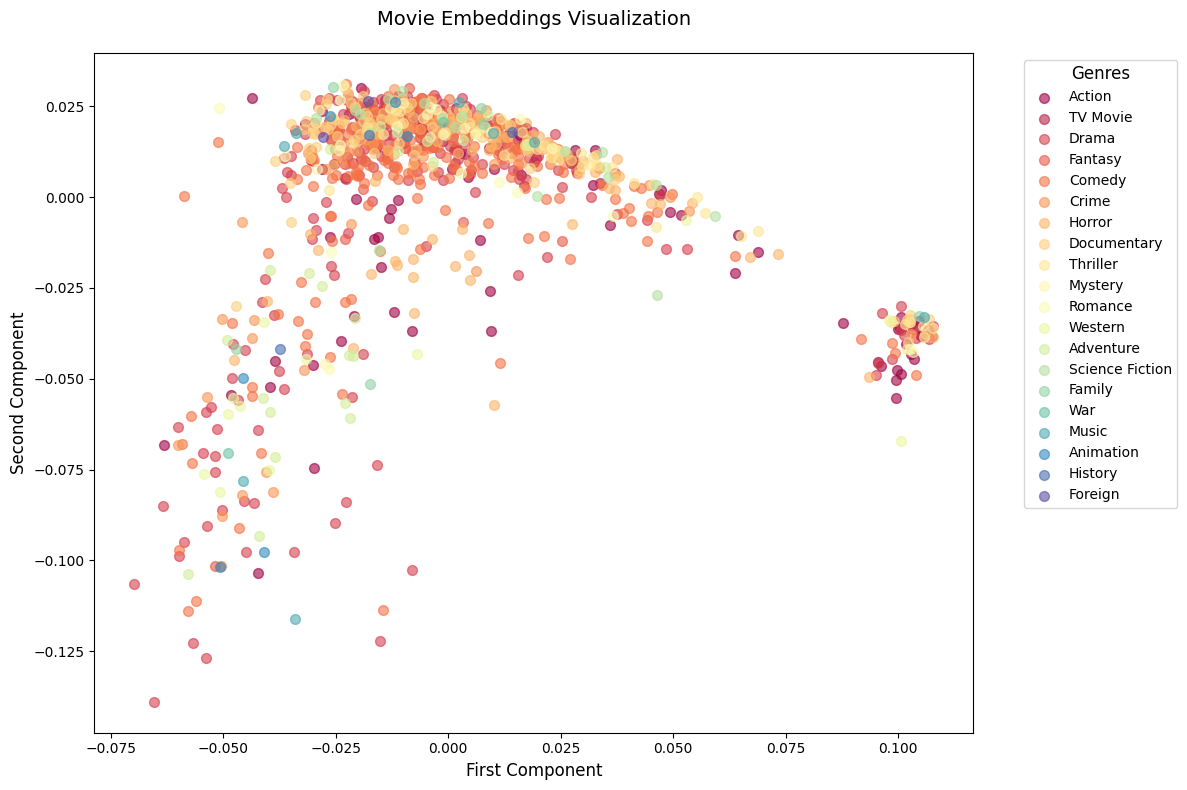

In [182]:
evaluater.visualize(decomp)

In [833]:
import glob 

movie_images = glob.glob('/Users/brighttenkorangofori/Desktop/recommender system/data/movies/*/*jpg')

In [1012]:

class Recommendation_Search:
    def __init__(self,predictions,images,df,indices,test_data):
        self.num = len(test_loader.dataset)
        
        self.predictions = predictions
        
        self.images = images 

        self.df = df
        
        self.test_data = test_data

        self.indices = indices
    
    
    def create_df(self):

        self.predictions_list  = [self.predictions[i] for i in range(len(self.predictions))]
        # Extract the relevant movie titles from the test_data range
        movie_titles = self.df['original_title'][-len(self.test_data):].tolist()
        self.df_subset = self.df[-len(self.test_data):].copy()
        
        # Step 1: Map indices to image paths and initialize a column for images
        index_to_image = {}
        found_indices = set()
        
        for image_path in self.images:
            # Extract the index from the image path
            index_str = image_path.split()[-2].split('/')[-1]
            index = int(index_str)
            
            # Map index to image path and mark as found
            index_to_image[index] = image_path
            found_indices.add(index)
        
        # Step 2: Identify missing indices by comparing with expected indices
        missing_indices = [idx for idx in self.indices if idx not in found_indices]
        
        # Step 3: Create new columns for titles, images, and predictions in the DataFrame subset
        
        self.df_subset['title'] = movie_titles
        self.df_subset['image_path'] = self.df_subset.index.map(index_to_image).fillna('Image not Found')
        self.df_subset['predictions'] = self.predictions_list
        
        return self.df_subset, missing_indices
    
    def search_movie(self, movie):
        # Get the index of the movie in the dataframe
       
        index = self.df_subset[self.df_subset.title == movie].index[0]
        
        # Extract the embedding for the movie from predictions
        embedd = self.df_subset.predictions[index]
        embedding_tensor = torch.tensor(embedd)

     
        # Convert the list of predictions to a tensor
        prediction_tensors = torch.stack([torch.tensor(prediction) for prediction in self.predictions_list])

        # Compute cosine similarities
        similarities = torch.cosine_similarity(embedding_tensor.unsqueeze(0), prediction_tensors)
        top5 = similarities.topk(k=7)
        print(top5)
        top5_indices = [int(i) for i in top5.indices]  # Convert indices to integers
        self.top5_indices = top5_indices[-6:]
        
        # Retrieve movie titles for the top 5 indices
        self.recommendations = [self.df_subset['title'].iloc[i] for i in self.top5_indices]

        print( {
            'search': movie,
            'recommendations': self.recommendations
        })

        return self.recommendations
    
    def get_images(self):
        print(self.top5_indices)
        images = [self.df_subset['image_path'].iloc[idx] for idx in self.top5_indices]
        fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(10, 10))
        axes = axes.flatten()  # Flatten the 3x3 grid to access axes easily in a loop

        for i in range(len(images)):
            image = plt.imread(images[i])  # Use the correct index to load each image
            axes[i].imshow(image)  # Show the image on the correct subplot
            axes[i].axis('off')  # Hide the axis for cleaner look

        plt.tight_layout()
        plt.show()

        return images 
      
    def get_images(self):
        print(self.top5_indices)
        images = [self.df_subset['image_path'].iloc[idx] for idx in self.top5_indices]
        fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(10, 10))
        axes = axes.flatten() # Flatten the 3x3 grid to access axes easily in a loop
        for i in range(len(images)):
            image = plt.imread(images[i]) # Use the correct index to load each image
            axes[i].imshow(image) # Show the image on the correct subplot
            axes[i].axis('off') # Hide the axis for cleaner look
        plt.tight_layout()
        plt.show()
        return images

    def launch_gradio(self):
        import gradio as gr
        from PIL import Image

        # Initialize the DataFrame
        self.df_subset, _ = self.create_df()

        def get_recommendations(movie_title):
            try:
                recommendations = self.search_movie(movie_title)
                image_paths = self.get_images()
                
                # Load and resize images
                images = []
                for path in image_paths:
                    try:
                        img = Image.open(path)
                        img = img.resize((200, 300))
                        images.append(img)
                    except Exception as e:
                        print(f"Error loading image {path}: {e}")
                        images.append(None)
                
                return {
                    movie_grid: images,
                    recommendation_text: "\n".join([f"{i+1}. {title}" for i, title in enumerate(recommendations)])
                }
            except Exception as e:
                return {
                    movie_grid: [None] * 6,
                    recommendation_text: f"Error: {str(e)}"
                }

        # Create the interface
        with gr.Blocks() as app:
            gr.Markdown("# Movie Recommendation System")
            
            with gr.Row():
                movie_input = gr.Textbox(
                    label="Enter a movie title",
                    placeholder="Type a movie title...",
                    scale=4
                )
                search_button = gr.Button("Get Recommendations", scale=1)
            
            with gr.Row():
                with gr.Column():
                    movie_grid = gr.Gallery(
                        label="Recommended Movies",
                        show_label=True,
                        elem_id="gallery",
                        columns=[3],
                        rows=[2],
                        height="auto"
                    )
                    recommendation_text = gr.Textbox(
                        label="Recommendations",
                        lines=6,
                        interactive=False
                    )
            
            search_button.click(
                fn=get_recommendations,
                inputs=[movie_input],
                outputs=[movie_grid, recommendation_text]
            )
        
        app.launch()

    

In [1013]:
search = Recommendation_Search(predictions=predictions,images = movie_images,df = df,test_data= test_data,indices=indices)

In [1014]:
df_subset, missing_indices = search.create_df()

In [1015]:
movies = search.search_movie("Tom Jones")

torch.return_types.topk(
values=tensor([1.0000, 0.9998, 0.9997, 0.9997, 0.9997, 0.9997, 0.9997]),
indices=tensor([493, 425, 152, 568, 474, 311, 507]))
{'search': 'Tom Jones', 'recommendations': ['Batman', "Donovan's Reef", "The Party's Over", 'Cotton Comes to Harlem', 'A Funny Thing Happened on the Way to the Forum', 'Love Me Tender']}


/var/folders/9m/fk8nf0sd56b7drjkrkbjx7580000gn/T/ipykernel_91149/137590000.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embedding_tensor = torch.tensor(embedd)
/var/folders/9m/fk8nf0sd56b7drjkrkbjx7580000gn/T/ipykernel_91149/137590000.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prediction_tensors = torch.stack([torch.tensor(prediction) for prediction in self.predictions_list])


In [1016]:
movies

['Batman',
 "Donovan's Reef",
 "The Party's Over",
 'Cotton Comes to Harlem',
 'A Funny Thing Happened on the Way to the Forum',
 'Love Me Tender']

[425, 152, 568, 474, 311, 507]


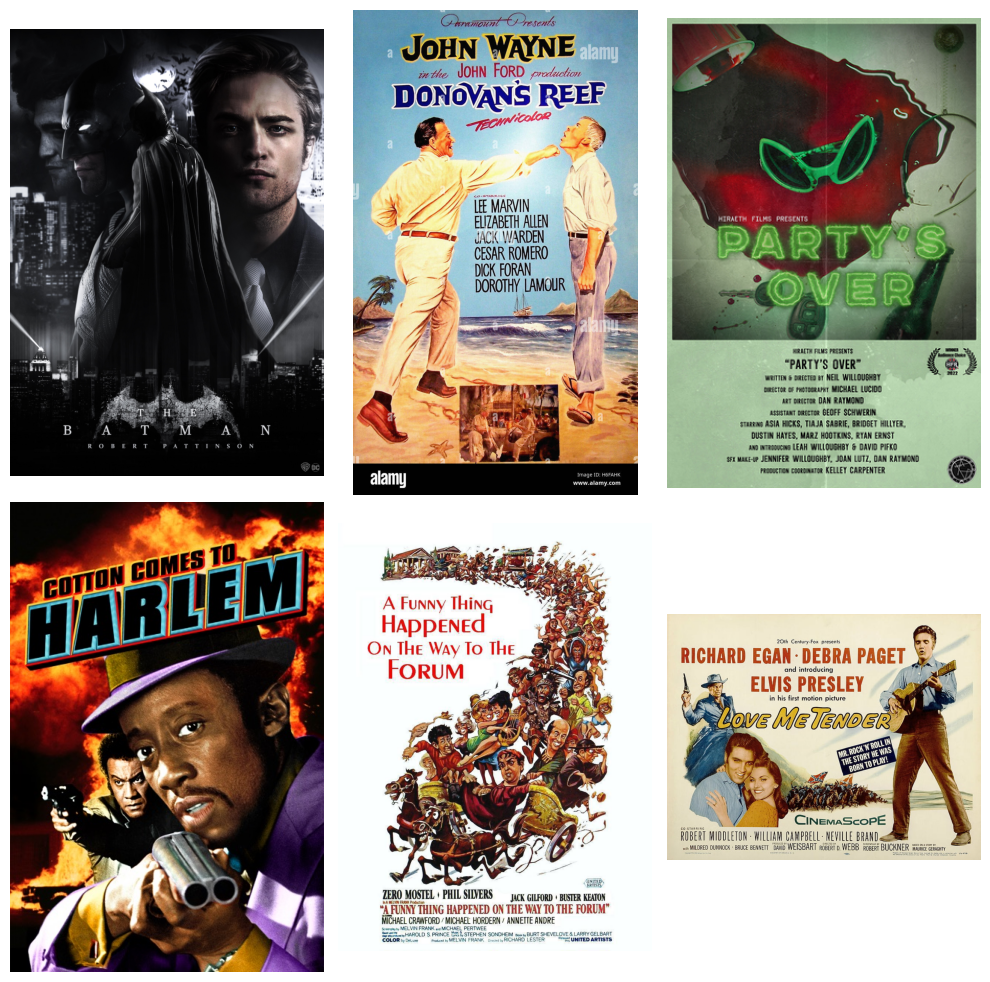

['/Users/brighttenkorangofori/Desktop/recommender system/data/movies/Batman movie 4267 /Image_1.jpg',
 "/Users/brighttenkorangofori/Desktop/recommender system/data/movies/Donovan's Reef movie 3994 /Image_1.jpg",
 "/Users/brighttenkorangofori/Desktop/recommender system/data/movies/The Party's Over movie 4410 /Image_1.jpg",
 '/Users/brighttenkorangofori/Desktop/recommender system/data/movies/Cotton Comes to Harlem movie 4316 /Image_1.jpg',
 '/Users/brighttenkorangofori/Desktop/recommender system/data/movies/A Funny Thing Happened on the Way to the Forum movie 4153 /Image_1.jpg',
 '/Users/brighttenkorangofori/Desktop/recommender system/data/movies/Love Me Tender movie 4349 /Image_1.jpg']

In [1017]:
search.get_images()

In [1000]:
import gradio as gr 
from io import BytesIO
from PIL import Image

In [ ]:
search.launch_gradio()

* Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


/var/folders/9m/fk8nf0sd56b7drjkrkbjx7580000gn/T/ipykernel_91149/137590000.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embedding_tensor = torch.tensor(embedd)
/var/folders/9m/fk8nf0sd56b7drjkrkbjx7580000gn/T/ipykernel_91149/137590000.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prediction_tensors = torch.stack([torch.tensor(prediction) for prediction in self.predictions_list])


torch.return_types.topk(
values=tensor([1.0000, 0.9998, 0.9997, 0.9997, 0.9997, 0.9997, 0.9997]),
indices=tensor([425, 493, 568,  57, 490, 506, 474]))
{'search': 'Batman', 'recommendations': ['Tom Jones', "The Party's Over", 'Beneath the Planet of the Apes', 'Silent Running', 'Beyond the Valley of the Dolls', 'Cotton Comes to Harlem']}
[493, 568, 57, 490, 506, 474]


/var/folders/9m/fk8nf0sd56b7drjkrkbjx7580000gn/T/ipykernel_91149/137590000.py:103: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


torch.return_types.topk(
values=tensor([1.0000, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998]),
indices=tensor([ 37,  68,  39, 669, 808, 536, 628]))
{'search': 'Adam', 'recommendations': ['Slow West', 'Beginners', 'Fireproof', 'Exam', 'Wristcutters: A Love Story', 'Safety Not Guaranteed']}
[68, 39, 669, 808, 536, 628]


Traceback (most recent call last):
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/queueing.py", line 624, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/route_utils.py", line 323, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/blocks.py", line 2025, in process_api
    data = await self.postprocess_data(block_fn, result["prediction"], state)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/blocks.py", line 1831, in postprocess_data
   

torch.return_types.topk(
values=tensor([1.0000, 0.9998, 0.9997, 0.9997, 0.9997, 0.9997, 0.9997]),
indices=tensor([425, 493, 568,  57, 490, 506, 474]))
{'search': 'Batman', 'recommendations': ['Tom Jones', "The Party's Over", 'Beneath the Planet of the Apes', 'Silent Running', 'Beyond the Valley of the Dolls', 'Cotton Comes to Harlem']}
[493, 568, 57, 490, 506, 474]
torch.return_types.topk(
values=tensor([1.0000, 0.9998, 0.9998, 0.9997, 0.9997, 0.9997, 0.9997]),
indices=tensor([490, 568, 585, 309, 341, 506, 671]))
{'search': 'Silent Running', 'recommendations': ["The Party's Over", 'Charly', 'Die Schlangengrube und das Pendel', "Hang 'em High", 'Beyond the Valley of the Dolls', 'Benji']}
[568, 585, 309, 341, 506, 671]
torch.return_types.topk(
values=tensor([1.0000, 0.9998, 0.9997, 0.9997, 0.9997, 0.9997, 0.9997]),
indices=tensor([671, 496, 149, 585, 490, 506,  18]))
{'search': 'Benji', 'recommendations': ['The Howling', 'The Black Stallion', 'Charly', 'Silent Running', 'Beyond the Valle

Traceback (most recent call last):
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/queueing.py", line 624, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/route_utils.py", line 323, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/blocks.py", line 2025, in process_api
    data = await self.postprocess_data(block_fn, result["prediction"], state)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/blocks.py", line 1831, in postprocess_data
   

torch.return_types.topk(
values=tensor([1.0000, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998]),
indices=tensor([ 30, 947, 115, 508, 758,  68, 851]))
{'search': 'Bella', 'recommendations': ['Clean', 'The Eclipse', 'An Inconvenient Truth', '51 Birch Street', 'Slow West', 'H.']}
[947, 115, 508, 758, 68, 851]


Traceback (most recent call last):
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/queueing.py", line 624, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/route_utils.py", line 323, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/blocks.py", line 2025, in process_api
    data = await self.postprocess_data(block_fn, result["prediction"], state)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/blocks.py", line 1831, in postprocess_data
   

torch.return_types.topk(
values=tensor([1.0000, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998]),
indices=tensor([ 30, 947, 115, 508, 758,  68, 851]))
{'search': 'Bella', 'recommendations': ['Clean', 'The Eclipse', 'An Inconvenient Truth', '51 Birch Street', 'Slow West', 'H.']}
[947, 115, 508, 758, 68, 851]


Traceback (most recent call last):
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/queueing.py", line 624, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/route_utils.py", line 323, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/blocks.py", line 2025, in process_api
    data = await self.postprocess_data(block_fn, result["prediction"], state)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/blocks.py", line 1831, in postprocess_data
   

torch.return_types.topk(
values=tensor([1.0000, 0.9998, 0.9997, 0.9997, 0.9997, 0.9997, 0.9997]),
indices=tensor([671, 496, 149, 585, 490, 506,  18]))
{'search': 'Benji', 'recommendations': ['The Howling', 'The Black Stallion', 'Charly', 'Silent Running', 'Beyond the Valley of the Dolls', 'High Anxiety']}
[496, 149, 585, 490, 506, 18]
torch.return_types.topk(
values=tensor([1.0000, 0.9998, 0.9998, 0.9997, 0.9997, 0.9997, 0.9997]),
indices=tensor([585,  18, 490,  66, 474, 671, 369]))
{'search': 'Charly', 'recommendations': ['High Anxiety', 'Silent Running', 'Torn Curtain', 'Cotton Comes to Harlem', 'Benji', 'La sirène du Mississipi']}
[18, 490, 66, 474, 671, 369]
torch.return_types.topk(
values=tensor([1.0000, 0.9998, 0.9997, 0.9997, 0.9997, 0.9997, 0.9997]),
indices=tensor([ 18, 585, 671, 496, 855, 299, 440]))
{'search': 'High Anxiety', 'recommendations': ['Charly', 'Benji', 'The Howling', "She's Gotta Have It", 'Bananas', 'Friday the 13th Part 2']}
[585, 671, 496, 855, 299, 440]
torch

Traceback (most recent call last):
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/queueing.py", line 624, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/route_utils.py", line 323, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/blocks.py", line 2025, in process_api
    data = await self.postprocess_data(block_fn, result["prediction"], state)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/blocks.py", line 1831, in postprocess_data
   

torch.return_types.topk(
values=tensor([1.0000, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998]),
indices=tensor([ 37,  68,  39, 669, 808, 536, 628]))
{'search': 'Adam', 'recommendations': ['Slow West', 'Beginners', 'Fireproof', 'Exam', 'Wristcutters: A Love Story', 'Safety Not Guaranteed']}
[68, 39, 669, 808, 536, 628]


Traceback (most recent call last):
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/queueing.py", line 624, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/route_utils.py", line 323, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/blocks.py", line 2025, in process_api
    data = await self.postprocess_data(block_fn, result["prediction"], state)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/blocks.py", line 1831, in postprocess_data
   

torch.return_types.topk(
values=tensor([1.0000, 0.9998, 0.9997, 0.9997, 0.9997, 0.9997, 0.9997]),
indices=tensor([425, 493, 568,  57, 490, 506, 474]))
{'search': 'Batman', 'recommendations': ['Tom Jones', "The Party's Over", 'Beneath the Planet of the Apes', 'Silent Running', 'Beyond the Valley of the Dolls', 'Cotton Comes to Harlem']}
[493, 568, 57, 490, 506, 474]
torch.return_types.topk(
values=tensor([1.0000, 0.9997, 0.9997, 0.9997, 0.9997, 0.9997, 0.9997]),
indices=tensor([474, 585, 341, 493, 425, 233, 655]))
{'search': 'Cotton Comes to Harlem', 'recommendations': ['Charly', "Hang 'em High", 'Tom Jones', 'Batman', 'Everything You Always Wanted to Know About Sex *But Were Afraid to Ask', 'Woodstock']}
[585, 341, 493, 425, 233, 655]
torch.return_types.topk(
values=tensor([1.0000, 0.9997, 0.9997, 0.9997, 0.9997, 0.9997, 0.9997]),
indices=tensor([655, 585, 632, 299, 231, 867,  63]))
{'search': 'Woodstock', 'recommendations': ['Charly', 'Il conformista', 'Bananas', 'Sleeper', 'A Charlie

Traceback (most recent call last):
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/queueing.py", line 624, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/route_utils.py", line 323, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/blocks.py", line 2025, in process_api
    data = await self.postprocess_data(block_fn, result["prediction"], state)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/blocks.py", line 1831, in postprocess_data
   

torch.return_types.topk(
values=tensor([1.0000, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998]),
indices=tensor([304, 214, 395, 483, 103, 444, 942]))
{'search': 'Highway', 'recommendations': ['Impact Point', 'Hatchet', 'Beyond the Black Rainbow', "Love's Abiding Joy", 'The Lion of Judah', 'The Puffy Chair']}
[214, 395, 483, 103, 444, 942]
torch.return_types.topk(
values=tensor([1.0000, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998]),
indices=tensor([395,  88,   2,   6, 304, 548, 861]))
{'search': 'Hatchet', 'recommendations': ['8 Heads in a Duffel Bag', 'La otra conquista', 'D.E.B.S.', 'Highway', 'The House of the Devil', 'Tadpole']}
[88, 2, 6, 304, 548, 861]


Traceback (most recent call last):
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/queueing.py", line 624, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/route_utils.py", line 323, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/blocks.py", line 2025, in process_api
    data = await self.postprocess_data(block_fn, result["prediction"], state)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/blocks.py", line 1831, in postprocess_data
   

torch.return_types.topk(
values=tensor([1.0000, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998]),
indices=tensor([304, 214, 395, 483, 103, 444, 942]))
{'search': 'Highway', 'recommendations': ['Impact Point', 'Hatchet', 'Beyond the Black Rainbow', "Love's Abiding Joy", 'The Lion of Judah', 'The Puffy Chair']}
[214, 395, 483, 103, 444, 942]
torch.return_types.topk(
values=tensor([1.0000, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998]),
indices=tensor([444, 103, 748, 595, 935, 483, 570]))
{'search': 'The Lion of Judah', 'recommendations': ["Love's Abiding Joy", 'Show Me', 'The Quiet', 'Manito', 'Beyond the Black Rainbow', 'The Poker House']}
[103, 748, 595, 935, 483, 570]
torch.return_types.topk(
values=tensor([1.0000, 0.9999, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998]),
indices=tensor([935, 566, 214, 323, 103, 944, 575]))
{'search': 'Manito', 'recommendations': ['Jimmy and Judy', 'Impact Point', 'Chacun sa nuit', "Love's Abiding Joy", 'Breaking Upwards', 'My Last Day Without You']}
[566, 

Traceback (most recent call last):
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/queueing.py", line 624, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/route_utils.py", line 323, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/blocks.py", line 2025, in process_api
    data = await self.postprocess_data(block_fn, result["prediction"], state)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/blocks.py", line 1831, in postprocess_data
   

torch.return_types.topk(
values=tensor([1.0000, 0.9998, 0.9997, 0.9997, 0.9997, 0.9997, 0.9997]),
indices=tensor([671, 496, 149, 585, 490, 506,  18]))
{'search': 'Benji', 'recommendations': ['The Howling', 'The Black Stallion', 'Charly', 'Silent Running', 'Beyond the Valley of the Dolls', 'High Anxiety']}
[496, 149, 585, 490, 506, 18]
torch.return_types.topk(
values=tensor([1.0000, 0.9998, 0.9998, 0.9997, 0.9997, 0.9997, 0.9997]),
indices=tensor([585,  18, 490,  66, 474, 671, 369]))
{'search': 'Charly', 'recommendations': ['High Anxiety', 'Silent Running', 'Torn Curtain', 'Cotton Comes to Harlem', 'Benji', 'La sirène du Mississipi']}
[18, 490, 66, 474, 671, 369]
torch.return_types.topk(
values=tensor([1.0000, 0.9997, 0.9997, 0.9997, 0.9997, 0.9997, 0.9997]),
indices=tensor([369, 585, 341, 655, 309, 776, 124]))
{'search': 'La sirène du Mississipi', 'recommendations': ['Charly', "Hang 'em High", 'Woodstock', 'Die Schlangengrube und das Pendel', 'Nothing But a Man', 'Point Blank']}
[585, 

Traceback (most recent call last):
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/queueing.py", line 624, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/route_utils.py", line 323, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/blocks.py", line 2025, in process_api
    data = await self.postprocess_data(block_fn, result["prediction"], state)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/blocks.py", line 1831, in postprocess_data
   

torch.return_types.topk(
values=tensor([1.0000, 0.9998, 0.9997, 0.9997, 0.9997, 0.9997, 0.9997]),
indices=tensor([671, 496, 149, 585, 490, 506,  18]))
{'search': 'Benji', 'recommendations': ['The Howling', 'The Black Stallion', 'Charly', 'Silent Running', 'Beyond the Valley of the Dolls', 'High Anxiety']}
[496, 149, 585, 490, 506, 18]
torch.return_types.topk(
values=tensor([1.0000, 0.9997, 0.9997, 0.9997, 0.9997, 0.9997, 0.9997]),
indices=tensor([506, 490, 671, 585, 425, 932, 233]))
{'search': 'Beyond the Valley of the Dolls', 'recommendations': ['Silent Running', 'Benji', 'Charly', 'Batman', 'Pink Narcissus', 'Everything You Always Wanted to Know About Sex *But Were Afraid to Ask']}
[490, 671, 585, 425, 932, 233]


Traceback (most recent call last):
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/queueing.py", line 624, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/route_utils.py", line 323, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/blocks.py", line 2025, in process_api
    data = await self.postprocess_data(block_fn, result["prediction"], state)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/blocks.py", line 1831, in postprocess_data
   

torch.return_types.topk(
values=tensor([1.0000, 0.9997, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996]),
indices=tensor([507, 493, 568, 152, 154, 215, 509]))
{'search': 'Love Me Tender', 'recommendations': ['Tom Jones', "The Party's Over", "Donovan's Reef", 'A Guy Named Joe', 'The Valley of Decision', 'Sands of Iwo Jima']}
[493, 568, 152, 154, 215, 509]
torch.return_types.topk(
values=tensor([1.0000, 0.9997, 0.9997, 0.9996, 0.9996, 0.9996, 0.9996]),
indices=tensor([154, 459, 215, 507, 509, 242, 446]))
{'search': 'A Guy Named Joe', 'recommendations': ['The Blue Bird', 'The Valley of Decision', 'Love Me Tender', 'Sands of Iwo Jima', 'Boom Town', 'How Green Was My Valley']}
[459, 215, 507, 509, 242, 446]
torch.return_types.topk(
values=tensor([1.0000, 0.9998, 0.9997, 0.9997, 0.9997, 0.9997, 0.9997]),
indices=tensor([425, 493, 568,  57, 490, 506, 474]))
{'search': 'Batman', 'recommendations': ['Tom Jones', "The Party's Over", 'Beneath the Planet of the Apes', 'Silent Running', 'Beyond the Valley 

Traceback (most recent call last):
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/queueing.py", line 624, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/route_utils.py", line 323, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/blocks.py", line 2025, in process_api
    data = await self.postprocess_data(block_fn, result["prediction"], state)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brighttenkorangofori/Desktop/recommender system/reco-venv/lib/python3.12/site-packages/gradio/blocks.py", line 1831, in postprocess_data
   